# Notebook - Swahili News Classification\\.

This notebook walks you through how you can leverage FastAI and Huggingface Transformers using BLURR. The beauty of course remains the ease (High level) nature of FastAI and the Awesome Pretained models on the Hugging Face hub.

# Understanding the Challenge.

The dataset describes 6439 rows of news from different sources in Tanzania.These news are in 5 different news categories from national news to entertainment news.

The goal is to accurately classify each swahili news content into five specified categories below:

Kitaifa (National)
Kimataifa (International)
Biashara (Business)
Michezo (Sports)
Burudani (Entertainment)

###### Mount your google colab drive

You can also skip this if you are uploading your data manually. Remember to edit the Paths

In [ ]:
# mount your google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


###### Installations.

* Install FastAI
* Install Blurr

[Blurr](https://github.com/ohmeow/blurr) is a library that extends the Fastai library to provide additional functionality for working with Transformers-based models for Natural Language Processing (NLP) tasks.

Some of the features of Blurr include:

* Support for various NLP tasks such as text classification, sequence labeling, and question-answering using pre-trained Transformer models like BERT, RoBERTa, etc.
* Convenience functions for loading data, preprocessing, and fine-tuning pre-trained models.
* Specialized training and validation callbacks for working with Transformer models in Fastai.


In [ ]:
!pip install huggingface_hub["fastai"] -qq

In [ ]:
! git clone https://github.com/ohmeow/blurr.git

Cloning into 'blurr'...
remote: Enumerating objects: 5397, done.
remote: Counting objects: 100% (1228/1228), done.
remote: Compressing objects: 100% (363/363), done.
remote: Total 5397 (delta 898), reused 1138 (delta 838), pack-reused 4169
Receiving objects: 100% (5397/5397), 36.37 MiB | 14.61 MiB/s, done.
Resolving deltas: 100% (4127/4127), done.


###### CD into Blurr to manage installations.

In [ ]:
%cd /content/blurr

/content/blurr


In [ ]:
!pip install -e ".[dev]" -qq

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 67.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

###### Import Libraries

In [ ]:
import numpy as np
import torch
import transformers
from fastai.text.all import *
import seaborn as sns
import matplotlib.pyplot as plt

from blurr.text.data.all import *
from blurr.text.modeling.all import *

###### Set Seed.

In [ ]:
def random_seed(seed_value, use_cuda):
  np.random.seed(seed_value)
  #cpu vars
  torch.manual_seed(seed_value)
  # cpu  vars
  random.seed(seed_value)
  # Python
  if use_cuda:
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    # gpu vars
    torch.backends.cudnn.deterministic = True
    #needed
    torch.backends.cudnn.benchmark = False
#Remember to use num_workers=0 when creating the DataBunch.

In [ ]:
random_seed(2023,True)

Check out FastAI

In [ ]:
import fastai
fastai.__version__

'2.7.15'

In [ ]:
torch.cuda.is_available()

True

###### Loading up your Data

Remember to edit the Paths!!!!!!

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/swahili-news/Train.csv")
test = pd.read_csv("/content/drive/MyDrive/swahili-news/Test.csv")
ss =   pd.read_csv("/content/drive/MyDrive/swahili-news/SampleSubmission.csv")

In [ ]:
train.tail()

,id,content,category
5146,SW993,"RAIS John Magufuli ameendelea kung’ara katika siasa za kimataifa mwaka huu, baada ya Taasisi ya Transparency International (TI), kuitaja Tanzania kuwa moja ya nchi zilizofanya vizuri katika masuala ya kupiga vita rushwa.Ripoti ya TI ya mwaka huu, iliyopatikana Dar es Salam juzi, imesema Tanzania imeendelea kufanya vizuri katika vita dhidi ya rushwa kubwa na ndogo, zinazohujumu uchumi na kuumiza wananchi wa kawaida wapatapo huduma.Rais Magufuli amekuwa kinara wa mapambanodhidi ya rushwa tangu aingie madararakani mwaka 2015, ambapo Tanzania imekuwa katika vita dhidi ya uhujumu uchumi na rus...",Kitaifa
5147,SW994,"KAMPENI inayohimiza watafi ti kuandika upya historia ya ukombozi wa nchi na Afrika kwa ujumla imeanza, lengo likiwa ni kuwezesha wanafunzi kusoma historia ambayo haijapotoshwa kwa makusudi.Akiwasilisha Makadirio ya Mapato na Matumizi ya Fedha kwa Mwaka 2019/20 bungeni jana, Waziri wa Habari, Utamaduni, Sanaa na Michezo, Dk Harrison Mwakyembe (pichani) alisema mbali na wizara yake kusimamia hilo, pia itafufua kampeni ya kurejesha fuvu la shujaa Leti Hema wa Wanyaturu na mashujaa wengine lililochukuliwa na Wajerumani wakati wa ukoloni.“Wizara itahimiza kampeni... kuwezesha wanafunzi na vija...",Kitaifa
5148,SW996,"MATUKIO mapya ya malaria kwa kila watu 1,000 katika jamii, yamepungua kwa asilimia 62 kutoka matukio 295 kwa kila watu 1,000 mwaka 2008 hadi matukio 112 kwa kila watu 1,000 .Hiyo ni kwa mujibu wa tafiti zilizofanywa mwaka 2008/2017 na Mpango wa Taifa wa Kudhibiti Malaria (NMCP) kwa kushirikiana na Wizara ya Afya, Maendeleo ya Jamii, Wazee na Watoto. Aidha vifo vinavyosababishwa na malaria, vimepungua kwa asilimia 73 kutoka vifo 33 kwa watu 1,000 katika jamii kwa mwaka 2008 hadi vifo 9 kwa watu 1,000 kwa mwaka 2017.Mhamasishaji Theresia Shirima kutoka NMCP, akizungumza na wanahabari kwenye...",Kitaifa
5149,SW997,"IMEELEZWA kuwa hakuna sheria yoyote inayokataza taarifa za Tume ya Haki za Binadamu na Utawala Bora kujadiliwa Bungeni endapo mbunge ataona kuna jambo la kuibua kutoka kwenye taarifa iliyoibuliwa.Akijibu swali la mbunge wa Mgogoni Dk Suleiman Ally Yusuf (CUF), kwa niaba ya Waziri wa Katiba na Sheria, Naibu Waziri wa Elimu, Sayansi na Teknolojia, William ole Nasha alisema kwamba tume imekuwa ikitimiza wajibu wake na ripoti zake ziwazi. Katika swali lake la msingi, mbunge huyo alikuwa anataka kujua kwa nini ripoti za tume hiyo haziwekwi wazi kwa umma na kama serikali haioni kuwa wakati umef...",Kitaifa
5150,SW999,"Akizungumza mara baada ya kutiwa saini kwa makubaliano hayo jana jioni Waziri wa Nchi Ofisi ya Waziri Mkuu Tawala za Mikoa na Serikali za Mitaa, Hawa Ghasia, alisema uwekezaji huo unatarajiwa kuleta manufaa kwa shirika hilo kwani uwekezaji wake pia utasaidia kutoa elimu kwa vitendo juu ya ufugaji kwa kada mbalimbali.Alisema miaka ya nyuma shirika hilo lilikuwa likisifika kwa ufugaji wa kuku kabla ya kusitisha shughuli hizo kutokana na uwepo wa sababu mbalimbali na kusababisha shirika hilo kukosa mapato yaliyokuwa yakitokana na uuzaji wa kuku na mayai.Mkurugenzi wa Shirika la Elimu Kibaha,...",Biashara


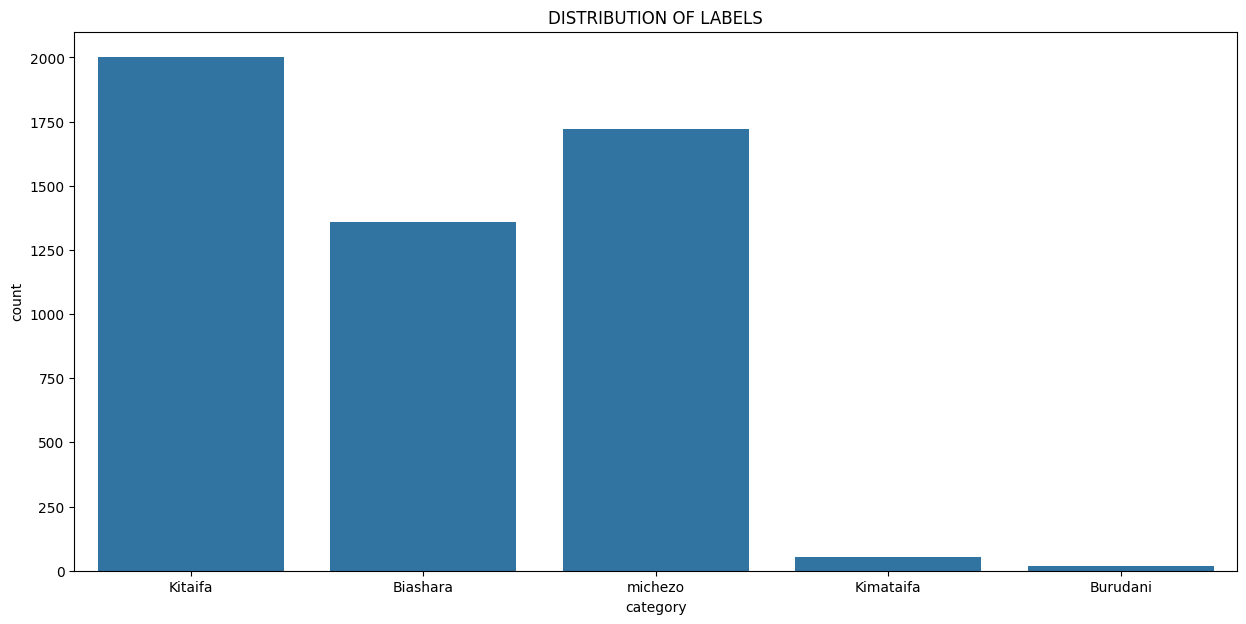

In [ ]:
# %Let's visualize the Label distiributions using seaborn
plt.figure(figsize=(15,7))
sns.countplot(x='category',data=train)
plt.title("DISTRIBUTION OF LABELS")
plt.show()

In [ ]:
# Define the clean_text function
def clean_text(sentence):
    '''
    Function to clean Swahili text.
    '''
    # Convert text to lower-case
    sentence = sentence.lower()

    # Remove unwanted characters, except for punctuation marks that indicate sentence boundaries
    sentence = re.sub('[‘’“”…,]', '', sentence)
    sentence = re.sub("[^a-zA-Z.?!]", " ", sentence)

    # Replace one or more whitespace characters with a single space
    sentence = re.sub('\s+', ' ', sentence)

    # Remove leading and trailing whitespace
    sentence = sentence.strip()

    return sentence

In [ ]:
# Clean the content column in test data
train['content'] = train['content'].apply(clean_text)

###### Training.

This code imports a pre-trained Transformer-based model for sequence classification, specifically the

* "flax-community/bert-swahili-news-classification" (ps: I found this pretrained model on huggingface hub, see if you'll find a better one)

model, and fine-tunes it for a given number of labels.

Here's a brief breakdown of what each line of code does:

* model_cls = transformers.AutoModelForSequenceClassification: This line assigns the AutoModelForSequenceClassification class from the Transformers library to the model_cls variable.


* pretrained_model_name = "flax-community/bert-swahili-news-classification": This line sets the name of the pre-trained model to ""flax-community/bert-swahili-news-classification"".


* config = transformers.AutoConfig.from_pretrained(pretrained_model_name): This line loads the configuration for the pre-trained model using the AutoConfig class from the Transformers library.


* config.num_labels = n_labels: This line sets the number of labels to be used in fine-tuning the model. The n_labels is defined below to be the number of classes in the label.


* Finally, we retrieve the architecture, configuration, tokenizer, and model instance of the pre-trained model, respectively, which will be used in fine-tuning the model for the new task.

In [ ]:
# Define your configurations
model_max_length = 256
padding = True
truncation = True

In [ ]:
n_labels = 5

In [ ]:
model_cls = transformers.AutoModelForSequenceClassification

pretrained_model_name = "flax-community/bert-swahili-news-classification"

config = transformers.AutoConfig.from_pretrained(pretrained_model_name)
# config.num_labels = n_labels


hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(
    pretrained_model_name,
    model_cls=model_cls,
    config=config
    )

config.json:   0%|          | 0.00/999 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/281 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/461k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
# Update tokenizer configurations
hf_tokenizer.model_max_length = model_max_length
hf_tokenizer.padding = padding
hf_tokenizer.truncation = truncation

###### Setting Up the Datablock

Now that we've retrieved the needed configs, we manipulate this to create the Datablock to take advantage of the ease and functionality of FastAI.

As usual, the DataBlock API requires an input and output to form the block.

In our case, the input is created from FastAI's TextBlock class where we specify how the data(input text) is processed and tokenized leveraging the configs from HuggingFace. The Output is a Category block since we have a category of classes.

For the other params in the datablock, it is the standard convention.

1. get_x: how to get the data from dataframe
2. get_y: how to get the labels from dataframe
3. Splitter: how you want to split train and validation set.

After all said and done, we create the dataloader.

In [ ]:
# single input - setting it up.
blocks = (
    TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model),
    CategoryBlock
)


# The datablock
dblock = DataBlock(
    blocks=blocks,
    get_x=ColReader("content"),
    get_y=ColReader("category"),
    splitter=TrainTestSplitter(0.05, stratify=train["category"]))

# Creating the dataloader.
dls = dblock.dataloaders(train, bs=4)

###### Check out one batch

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2)

,text,target
0,manchester united imejiondoa katika harakati ya kutaka kumsaini beki wa leicester na uingereza harry maguire baada ya kuambiwa kwamba mchezaji huyo mwenye umri wa miaka atagharimu m. mirror mkufunzi wa klabu ya nice nchini ufaransa patrick vieira mkufunzi wa klabu ya rangers steven gerrard kocha wa manchester city mikel arteta wameorodheshwa miongoni mwa wakufunzi wanaotarajiwa kumrithi rafael benitez. telegraph raia wa uhispania mikel arteta ameungwa mkono kuchukua ukufunzi wa klabu ya manchester city wakati kocha pep guardiola atakapoondoka katika klabu hiyo. evening standard mkufunzi wa klabu ya burnley sean dyche pia analengwa na newcastle lakini the magpies watalazimika kuwalipa burnley m kama fidia. daily mail manchester united itakutana na ajenti wa kiungo wa kati wa portugal bruno fernandes ili kujaribu kumrai kuhamia katika klabu hiyo kwa dau la m kutoka klabu ya sporting lisbon. o jogo via talksport juventus imeitaka kampuni ya vifaa vya michezo adidas kuisaidia kifedha ili kuweza kumsaini kiungo wa kati wa manchester united na ufaransa paul pogba. corriere dello sport in italian manchester city iko katika mzungumzo na juventus kuhusu usajili wa beki wa kulia wa ureno joao cancelo. tuttomercato via star kiungo wa kati wa arsenal na uruguay lucas torreira anasema kuwa ac milan haijawasiliana naye kuhusu,michezo
1,arsenal wanatarajiwa kuanzisha mazungumzo na barcelona kuhusu kumsajili kiungo wa kati wa brazil phillipe coutinho hatua ambayo itaigharimu klabu hiyo dau la m. sun on sunday manchester united wamewasilisha ombi la dau la m kumsajili mchezaji wa ajax mwenye umri wa miaka na raia wa brazil david neres. yahoo in portuguese mchezaji wa ufaransa na manchester united paul pogba anahofia huenda akashindwa kuelekea real madrid huku mabingwa hao wa uhispania wakikabiliwa na dau la m kumsajili mchezaji huyo mwenye umri wa miaka kutoka manchester united. sunday mirror bayern munich wanakaribia kumsajili winga wa manchester city raia wa ujerumani leroy sane baada ya kukubali kandarasi na masharti na mchezaji huyo mwenye umri wa miaka. sky sport germany in german sane anakabiliwa na uwezekano wa kupoteza m katika mshahara wake iwapo ataendelea kukataa kutia kandarasi mpya na man city. sunday mirror mkufunzi wa manchester city pep guardiola anapima uwezekano wa kumsaini kiungo wa kati wa real madrid isco na beki wa bournemouth nathan ake. sunday express manchester united wamefanya mazungumzo ya kubadilishana wachezaji na juventus ambapo mchezaji wa argentina paulo dybala na mshambuliaji wa croatia mario mandzukic wataelekea old trafford huku naye mchezaji wa ubelgiji romelu lukaku akielekea juventus. sunday times subscription required mkufunzi wa crystal palace roy hodgson anataka kumsaini beki wa zamani wa uingereza gary cahill kwa mkopo wa miaka miwili. sun on sunday,michezo


Again, Let Blurr and FastAI handle everything.

Blurr's BaseModelWrapper helps convert your Hugging Face model into a FastAI compatible format.

Then we create a learner that takes in the data, model, optimizer function, loss function, metric, the callback function and the splitter.

The two interesting/new things here are the Base Model callback and the Blurr splitter. What they do is very simple.

* BaseModelCallback has a set of convenience functions that help handle tweaks in the trainig loop; Freeze and Unfreeze layers, applies discriminative learning rates to different layers of the model, etc.

* The Blurr Splitter helps split the model itself. Remember that we want to fine_tune, and we need to intelligently split the head and body of the model. The Blurr splitter does this based on the model architecture convention.

You can go deeper about this in the Blurr docs [here:](https://ohmeow.github.io/blurr/text.modeling.core.html)

After all said and done, you can hit the button on fit_one_cycle [following the official example](https://github.com/ohmeow/blurr) or of course you can fine_tune directly if you want.

In [ ]:
model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    hf_model,
    opt_func=partial(Adam, decouple_wd=True),
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter,
)

learn.freeze()
learn.summary()

BaseModelWrapper (Input shape: 4 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 256 x 768       
Embedding                                 23440896   False     
Embedding                                 393216     False     
Embedding                                 1536       False     
LayerNorm                                 1536       True      
Dropout                                                        
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
Dropout                                                        
Linear                                    590592     False     
LayerNorm                                 1536       True      
Dropout                                                        
____________________________________________________________________________
         

In [ ]:
print(len(learn.opt.param_groups))

4


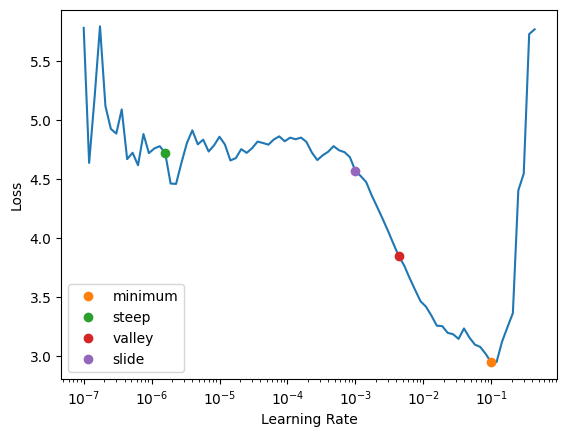

In [ ]:
lrs = learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(1,  lrs.valley)

epoch,train_loss,valid_loss,accuracy,time
0,0.278807,0.190941,0.930233,02:36


Check out what a good learning rates look like

In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,text,target,prediction
0,rais john magufuli amewaagiza wafanyabiashara kulipa kodi kwa wakati kutotoa rushwa na kuripoti wanapoomba rushwa. akizungumza na wafanyabiasha ikulu jana rais magufuli aliwapongeza wafanyabiashara hao kufika katika mkutano huo kwa gharama zao na pia kutoa michango yao kwa lengo la kuboresha huduma za serikali lakini pia mazingira ya biashara. alisema lengo la mkutano huo ilikuwa ni kueleza changamoto mbalimbali zinazosababisha kodi isikusanywe ipasavyo ambapo alikumbusha kuwa kazi ya mamlaka ya,Kitaifa,Kitaifa
1,wakazi wa kanda ya ziwa victoria wanakumbuka vizuri zama za nyuma namna walivyokuwa wakinufaika na bandari zilizo kando ya ziwa hilo kubwa nchini linaloiunganisha pia tanzania na nchi za kenya na uganda. huku meli maarufu za mv victoria mv serengeti mv umoja mv butiama na mv bukoba iliyozama zikifanya kazi wananchi walipendelea sana usafiri wa majini. licha ya kuwa usafiri wa starehe kwani meli ni sawa na nyumba mtu alikuwa anaweza kusafiri kwa njia ya maji akiwa na mzigo mkubwa hadi tani moja a,Kitaifa,Kitaifa


Take a peek

In [ ]:
learn.model

BaseModelWrapper(
  (hf_model): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bi

In [ ]:
learn.unfreeze()

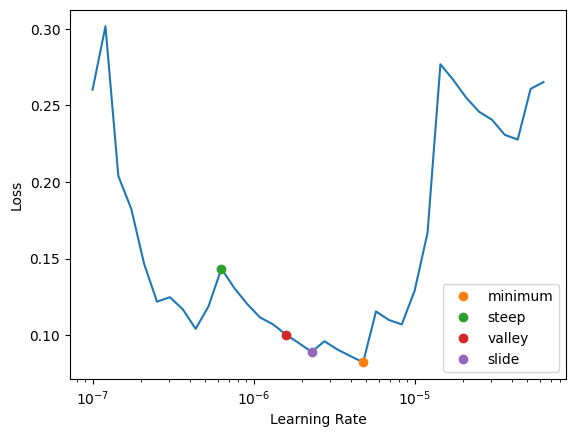

In [ ]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

Fine tune model

In [ ]:
learn.fit_one_cycle(3,slice(lrs.valley,lrs.minimum))

epoch,train_loss,valid_loss,accuracy,time
0,0.154031,0.168061,0.941860,04:23
1,0.184581,0.174682,0.914729,04:22
2,0.166418,0.167965,0.937984,04:22


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

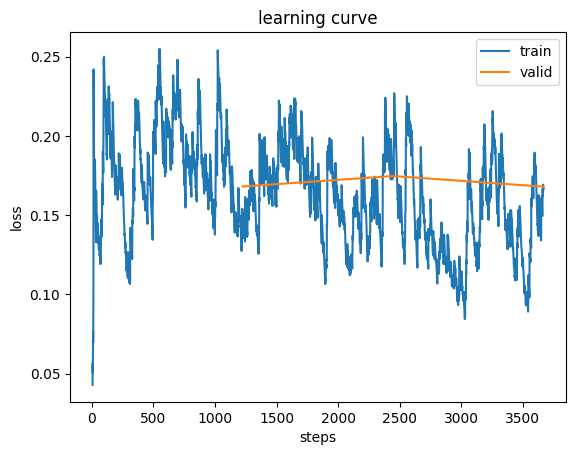

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)


,text,target,prediction
0,rais john magufuli amewaagiza wafanyabiashara kulipa kodi kwa wakati kutotoa rushwa na kuripoti wanapoomba rushwa. akizungumza na wafanyabiasha ikulu jana rais magufuli aliwapongeza wafanyabiashara hao kufika katika mkutano huo kwa gharama zao na pia kutoa michango yao kwa lengo la kuboresha huduma za serikali lakini pia mazingira ya biashara. alisema lengo la mkutano huo ilikuwa ni kueleza changamoto mbalimbali zinazosababisha kodi isikusanywe ipasavyo ambapo alikumbusha kuwa kazi ya mamlaka ya,Kitaifa,Kitaifa
1,wakazi wa kanda ya ziwa victoria wanakumbuka vizuri zama za nyuma namna walivyokuwa wakinufaika na bandari zilizo kando ya ziwa hilo kubwa nchini linaloiunganisha pia tanzania na nchi za kenya na uganda. huku meli maarufu za mv victoria mv serengeti mv umoja mv butiama na mv bukoba iliyozama zikifanya kazi wananchi walipendelea sana usafiri wa majini. licha ya kuwa usafiri wa starehe kwani meli ni sawa na nyumba mtu alikuwa anaweza kusafiri kwa njia ya maji akiwa na mzigo mkubwa hadi tani moja a,Kitaifa,Kitaifa


# Preparing your submission

In [ ]:
tdl = learn.dls.test_dl(test['content'])
test_preds_tta, test_labels_tta = learn.tta(dl=tdl)

In [ ]:
preds_test = test_preds_tta

In [ ]:
preds_test[0]

tensor([2.9798e-04, 6.5228e-05, 1.3445e-04, 9.9799e-01, 1.5088e-03, 1.6657e-06])

In [ ]:
k = np.unique(train.category).tolist()
import os
submission = ss.copy()
for i, c in enumerate(k):
  submission[c] = preds_test[:,i]
submission = submission[['swahili_id', "Kitaifa"   ,"michezo"   ,"Biashara"   ,"Kimataifa"   ,"Burudani"]] # Get same order as sample sub
submission.head()

,swahili_id,Kitaifa,michezo,Biashara,Kimataifa,Burudani
0,001dd47ac202d9db6624a5ff734a5e7dddafeaf2,0.997992,0.001509,0.000298,0.000134,0.000065
1,0043d97f7690e9bc02f0ed8bb2b260d1d44bad92,0.023019,0.975983,0.000706,0.000058,0.000223
2,00579c2307b5c11003d21c40c3ecff5e922c3fd8,0.307464,0.000678,0.690466,0.001365,0.000025
3,00868eeee349e286303706ef0ffd851f39708d37,0.991432,0.007406,0.000298,0.000766,0.000093
4,00a5cb12d3058dcf2e42f277eee599992db32412,0.902231,0.002671,0.094811,0.000253,0.000032


If you wish, check out distribution of your prediction and compare to the Train set

In [ ]:
class_list = k
class_indexes = np.argmax(preds_test, axis=1)
classes = [class_list[idx] for idx in class_indexes]

In [ ]:
pd.Series(classes).value_counts()

Kitaifa      525
michezo      443
Biashara     306
Kimataifa     11
Burudani       3
Name: count, dtype: int64

In [ ]:
train.category.value_counts()

category
Kitaifa      2000
michezo      1720
Biashara     1360
Kimataifa      54
Burudani       17
Name: count, dtype: int64

Hit the Submit button

In [ ]:
name = "sc_submission5.csv"
submission.to_csv(name, index=False)
from google.colab import files
files.download(name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Save the trained model
learn.export('model.pkl')